# Tarefa 04 - Verificação Facial com Redes Siamesas
## Alunos: Liselene Borges e Marcos Scarpim

Nesta tarefa, você irá construir e treinar uma rede siamesa para o problema de verificação facial. A rede irá receber um par de imagens e deverá dizer se elas foram tiradas da mesma pessoa ou de pessoas diferentes. Para isso, pedimos que você defina o modelo da sua arquitetura siamesa, carregue os dados, treine a rede e avalie sua performance no conjunto de teste.

------------
## IMPORTANTE
##### Verifique os pontos abaixo antes de começar a tarefa:
- Faça o download dos dados em https://goo.gl/yoEBsF e descomprima na mesma pasta deste notebook.
- Verifique se a pasta `INF0618-Tarefa04-faces` está no mesmo diretório deste notebook. Ela deverá conter as pastas `train`, `test`, `val` e também os arquivos `train_pairs.txt`, `test_pairs.txt` e `val_pairs.txt`. 
- Não há necessidade de alterar os códigos das sessões `Imports` e `Dataset`.
-----------


As tarefas são:

**1) Definição da arquitetura [0.3 pts]**
- Defina a arquitetura base que será utilizada em cada branch da rede siamesa;
- Defina os inputs e conecte-os a arquitetura base;
- Calcule a distância euclideana dos outputs de cada branch;

**2) Treinamento [0.3 pts]**
- Compile o seu modelo, definindo a contrastive loss e qual o otimizador que será utilizado;
- Defina também número de batches e número de épocas;
- Treine para obter a maior acurácia que vocês conseguirem;

**3) Teste [0.15 pts]**
- Avalie o conjunto de teste e reporte a loss e a acurácia normalizada;

**4) Conclusões [0.25 pts]**
- Escreva um parágrafo resumindo o que você fez, as dificuldades que encontrou, o que deu certo/errado e as suas conclusões desta atividade.

------

## Imports

In [12]:
import os
import numpy as np
from random import sample

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

from keras.preprocessing.image import load_img, img_to_array

#Add other imports that you might need
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Convolution2D, MaxPooling2D
from keras.models import Model
from keras import backend as K
from keras import regularizers

# Dataset
O dataset é composto de imagens de faces em diversas condições de iluminação e expressões faciais. As imagens foram centralizadas em relação às posições dos olhos. As identidades foram divididas de forma disjunta entre os conjuntos treino/validação/teste, que contam com 37/22/8 indivíduos com número variado de imagens por identidade.

Dentro de cada conjunto, criamos todas as combinações de pares da mesma identidade (classe positiva) e limitamos a quantidade de pares de identidades diferentes (classe negativa) por este número. Dessa forma, cada conjunto está balanceado nas classes.

** IMPORTANTE NÃO ALTERAR O NOME/LOCAL DAS IMAGENS** 

In [13]:
datasetDir = "./INF0618-Tarefa04-faces"
trainPairFile = datasetDir + "/train_pairs.txt"
valPairFile = datasetDir + "/val_pairs.txt"
testPairFile = datasetDir + "/test_pairs.txt"

input_shape = (112,112,3)

def preProcessPair(line):
    img1Path, img2Path, label = line.strip().split("\t")

    img1 = img_to_array(load_img(img1Path, target_size=input_shape))
    img1 = img1.astype('float32')
    img1 /= 255.0

    img2 = img_to_array(load_img(img2Path, target_size=input_shape))
    img2 = img2.astype('float32')
    img2 /= 255.0
    
    label = int(label)
    
    return img1, img2, label
    
#Read our dataset in batches
def loadDatasetInBatches(pairFile = trainPairFile, batch_size=32, shouldAugmentData=False):

    ######### If you want to run with Data Augmentation, just uncomment here and some lines bellow
    ##### you can add more transformations (see https://keras.io/preprocessing/image/)
    #if shouldAugmentData == True:
        #dataAugmentator = ImageDataGenerator(...)
    

    with open(pairFile, "r") as f:
        lines = f.readlines()
    
    while True:
        shuffledLines = sample(lines, len(lines)) #shuffle images in each epoch
        
        leftBatch, rightBatch, labelList = [], [], []
        nInBatch = 0
        
        #loop of one epoch
        for idx in list(range(len(shuffledLines))):
                        img1, img2, label = preProcessPair(shuffledLines[idx])
    
                        ### We apply a random transformation and add this image (instead of the original)
                        ### to the batch...
                        #if shouldAugmentData == True:
                            #img1 = dataAugmentator.random_transform(img1)
                            #img2 = dataAugmentator.random_transform(img2)
    
                        leftBatch.append(img1)
                        rightBatch.append(img2)
                        labelList.append(label)
                        nInBatch += 1
                        
                        #if we already have one batch, yields it
                        if nInBatch >= batch_size:
                            yield [np.array(leftBatch),np.array(rightBatch)], np.array(labelList)
                            leftBatch, rightBatch, labelList = [], [], []
                            nInBatch = 0

        #yield the remaining of the batch
        if nInBatch > 0:
            yield [np.array(leftBatch),np.array(rightBatch)], np.array(labelList)

def getDatasetSize(pairFile):
    with open(pairFile, "r") as f:
        lines = f.readlines()
    return len(lines)

               
def plotPair(img1, img2):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(121)
    ax.imshow(np.uint8(img1.reshape(input_shape)*255.0), interpolation='nearest')
    
    ax = fig.add_subplot(122)
    ax.imshow(np.uint8(img2.reshape(input_shape)*255.0), interpolation='nearest')
    plt.show()
    
trainSetSize = getDatasetSize(trainPairFile)
valSetSize = getDatasetSize(valPairFile)
testSetSize = getDatasetSize(testPairFile)

print("# pairs in Train set: ", trainSetSize)
print("# pairs in Val set: ", valSetSize)
print("# pairs in Test set: ", testSetSize)

# pairs in Train set:  245338
# pairs in Val set:  22502
# pairs in Test set:  19038


Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 1


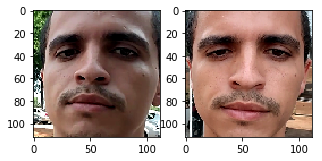

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 0


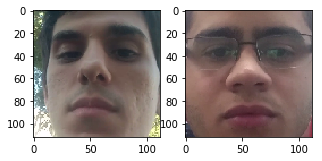

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 0


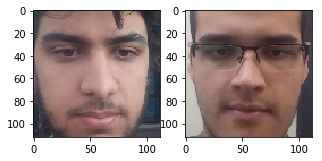

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 0


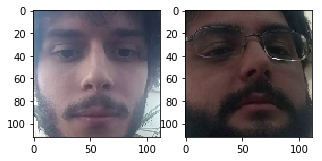

Image1 size:  (112, 112, 3) 	 Image2 size:  (112, 112, 3) 	 Label: 1


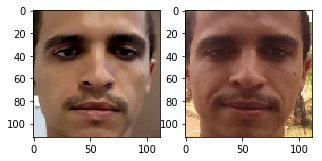

In [14]:
for batch, labels in loadDatasetInBatches(trainPairFile, batch_size=5):
    idx = 0
    leftBatch, rightBatch = batch
    for idx in list(range(leftBatch.shape[0])):
        print("Image1 size: ", leftBatch[idx].shape, "\t", "Image2 size: ", rightBatch[idx].shape,"\t Label:", labels[idx])
        plotPair(leftBatch[idx], rightBatch[idx])
    break

### Como o load do dados é feito...  
De forma parecida com o que foi feito na Tarefa03, iremos utilizar o método `loadDatasetInBatches(pairFile = trainPairFile, batch_size=32)`. Ele é um generator, ou seja, ele gera um fluxo de batches e labels a partir do nosso dataset.

**Argumentos**:
- (string) **pairFile**: se refere a qual conjunto de dados que iremos ler (treino, validação ou teste). Recebe um dos arquivos de pares definido anteriormente (trainPairFile, valPairFile, testPairFile);
- (int) **batch_size**: quantos pares por batch;

**Retorno**: 
- **batch**: retorna uma lista com 2 arrays numpy (um contendo todas as 1as imagens de cada par e outro contendo as 2as imagens de cada par). **batch** é uma lista de tamanho 2 e cada posição é array numpy com dimensões `(batch_size, 112, 112, 3)` pois são **batch_size** imagens com tamanho 112x112 e 3 canais (RGB);
- **labels**: retorna um array do numpy com as labels (1 para "mesma identidade" e 0 p/ "identidades diferentes");
    
Utilizando o argumento `pairFile`, o método lê as linhas do arquivo de pares e as embaralha (para garantir que a cada época os batches sejam diferentes). Para cada época (um loop do `for` interno), o método irá carregar um par por vez carregar e pre-processas ambas imagens. A primeira imagem do par será guardada em `leftBatch`, a segunda em `rightBatch` e a label em `labelList`.

Quando estas listas estiverem com **batch_size** elementos, teremos gerado um batch. O método dá um yield nas lista [`leftBatch`, `rightBatch`] e na `labelList` e recomeça a construção de um novo batch. Quando o `for` terminar, iremos ter completado uma época. O `while True` apenas garante uma nova época seja iniciada. Quem controlará o fim do `while` vai ser o método que fará o fit, portanto não precisamos nos preocupar com isso.  

-----------
-----------
-----------
** -----> A tarefa começa aqui !!! Vocês não precisam modificar nada dos códigos acima!** 

# Definição da arquitetura siamesa [0.3 pts]
- Defina a arquitetura base que será utilizada em cada branch da rede siamesa;
- Defina os inputs e conecte-os a arquitetura base;
- Calcule a distância euclideana dos outputs de cada branch;

In [15]:
#Defina sua arquitetura

#Compute classification accuracy with a fixed threshold on distances.
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

#Compute the euclidean distance of two arrays
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

#Base network to be shared (eq. to feature extraction).
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Convolution2D(10,(3,3),activation='relu')(input) 
    x = MaxPooling2D((2,2))(x) #diminui os mapas de ativação
    x = Convolution2D(20,(3,3),activation='relu')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x) #25% dos neuronios sao desligados aleatoriamente
    x = Dense(128,activation='relu',kernel_regularizer = regularizers.l2(0.01))(x)
    
    return Model(input,x)

# network definition
base_network = create_base_network(input_shape) #input_shape é o tamanho

#duas redes treinadas compartilhando os mesmos pesos
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

enconding_a = base_network(input_a)
enconding_b = base_network(input_b)

distance = Lambda(euclidean_distance)([enconding_a, enconding_b])

model = Model([input_a,input_b],distance)


# Treinamento [0.3 pts]
- Compile o seu modelo, definindo a contrastive loss e qual o otimizador que será utilizado;
- Defina também número de batches e número de épocas;
- Treine para obter a maior acurácia que vocês conseguirem;

Da mesma forma que na Tarefa03, iremos utilizar o `fit_generator` para otimizar nossa rede. Ele recebe um generator (que será fornecido pelo `loadDatasetInBatches`). Como o generator retorna um fluxo de batches/labels, o `fit_generator` não tem informação sobre o tamanho dataset. Por isso, precisamos informar o número de épocas (parâmetro `epochs`) e também quantos batches compõe uma época (parâmetro `steps_per_epoch`). Ao total, teremos 2 generators, um para o conjunto de treino e outro para o conjunto de validação.

Para mais informações sobre o fit_generator e seus parâmetros, [acesse a documentação do Keras](https://keras.io/models/sequential/#fit_generator).

In [16]:
#Compile o modelo / Defina a loss 
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

# Compilation
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy]) #<-- different accuracy metric

# Training
#model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
#          batch_size=32, epochs=2,
#          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

In [17]:
#Definir tamanho do batch e número de épocas
batch_size = 256
epochs = 2

#Criação dos generators
# IMPORTANTE ---> Se for utilizar data augmentation, passe a flag shouldAugmentData como True no treinamento
trainGenerator = loadDatasetInBatches(trainPairFile, batch_size = batch_size) #shouldAugmentData = True
valGenerator = loadDatasetInBatches(valPairFile, batch_size = batch_size) #shouldAugmentData = False

#Fit nos dados
model.fit_generator(trainGenerator, 
                    steps_per_epoch= int(trainSetSize / batch_size), 
                    epochs = epochs,
                    validation_data = valGenerator,  
                    validation_steps = int(valSetSize / batch_size))

Epoch 1/2
958/958 [==============================] - 4935s 5s/step - loss: 0.1142 - accuracy: 0.9582 - val_loss: 0.1838 - val_accuracy: 0.7777
Epoch 2/2
958/958 [==============================] - 5231s 5s/step - loss: 0.0521 - accuracy: 0.9879 - val_loss: 0.1862 - val_accuracy: 0.7676


# Teste [0.15 pts]
O teste será feito da mesma forma, utilizando `loadDatasetInBatches` para o conjunto de teste. 

In [18]:
#Criação do generator p/ o conjunto de teste
testGenerator = loadDatasetInBatches(testPairFile, batch_size=batch_size)

#Teste
metrics = model.evaluate_generator(testGenerator, 
                                   steps=int(testSetSize/batch_size), 
                                   verbose=1)

print("Test Loss ---> ", metrics[0])
print("Test Accuracy ---> ", metrics[1])    #Test is balanced, so Acc is normalized

74/74 [==============================] - 281s 4s/step
Test Loss --->  0.14387254014208511
Test Accuracy --->  0.8497677364864865


# Conclusões  [0.25 pts]
Escreva um parágrafo com as conclusões que você tirou na tarefa. Comente as dificuldades encontradas, as tentativas feitas, como foi o seu treinamento, apontando a motivação pelas decisões tomadas. Se o resultado ficou melhor/pior do que o que você esperava, o que você acha que pode ter acontecido?

In [ ]:
# ...